In [1]:
!pip install sentence_transformers
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import regex as re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, MeanShift, AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
# !pip install hdbscan
# !pip install sentence_transformers

**Importing CSV with dataset**

In [187]:
df = pd.read_csv('salad_data.csv')
df.columns = ['salad_info']
df.head()

,salad_info
0,Taco Salad Chip Dip\n\nIngredients:\n- 8 oz. O...
1,Broccoli Salad\n\nIngredients:\n- 1 large head...
2,Punch Bowl Fruit Salad\n\nIngredients:\n- 2 la...
3,Summer Spaghetti\n\nIngredients:\n- 1 lb. very...
4,Pear-Lime Salad\n\nIngredients:\n- 1 (16 oz.) ...


**Analysing dataset**

In [188]:
df_len,_ = df.shape
df_len

1498

In [189]:
df['Original_text'] = df['salad_info']

In [190]:
print(df['salad_info'][0])

Taco Salad Chip Dip

Ingredients:
- 8 oz. Ortega taco sauce
- 8 oz. sour cream
- 8 oz. cream cheese
- 1 lb. ground beef
- 1 pkg. taco seasoning
- shredded lettuce
- 1 large diced tomato
- 1 medium diced onion
- 1 large diced green pepper
- shredded Colby or Cheddar cheese

Directions:
- Mix taco sauce, sour cream and cream cheese.
- Spread on pizza pan.
- Brown meat.
- Drain off fat and add taco seasoning.
- Spread over cream mixture.
- Layer with raw vegetables.
- Top with cheese. Serve with chips.


In [191]:
print(df['salad_info'][df_len-1])

Macaroni Lunch

Ingredients:
- 1 small pkg. elbow macaroni, cooked and drained
- 1 1/2 lb. pan-fry sausage
- 1 large can (28 oz.) tomatoes
- 1 small can (8 oz.) tomato sauce and 1 can water*
- salt and pepper to taste
- 1 tsp. canola oil
- 1/2 tsp. celery seed

Directions:
- Pan fry sausage into crumbled pieces and drain on paper towels.
- In a large boiler, bring to boil tomatoes, tomato sauce, water (add more or less water according to your liking), salt and pepper, oil and celery seed.
- Add sausage and macaroni.
- Stir well, turn off, place on lid and leave covered 5 minutes.
- Serve with crackers and salad or coleslaw.


**Preprocessing functions**

In [192]:
def removeStopwords(text):
    stop_words = set(stopwords.words('english'))
    # all verbs also must be removed
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    non_verbs = [word for word, tag in pos_tags if not tag.startswith('VB')]
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [193]:
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lWords = [lemmatizer.lemmatize(word) for word in words]
    lText = ' '.join(lWords)
    return lText

In [194]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'oz', '', text)
    text = re.sub(r'lb', '', text)
    text = re.sub(r'[\d_]+', '', text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text

In [195]:
df['salad_info'] = df['salad_info'].apply(preprocess)

In [196]:
print(df['salad_info'][0])

taco salad chip dip ingredient ortega taco sauce sour cream cream cheese ground beef pkg taco seasoning shredded lettuce large diced tomato medium diced onion large diced green pepper shredded coy cheddar cheese direction mix taco sauce sour cream cream cheese spread pizza pan brown meat drain fat add taco seasoning spread cream mixture layer raw vegetable top cheese serve chip


In [197]:
print(df['salad_info'][df_len-1])

macaroni lunch ingredient small pkg eow macaroni cooked drained panfry sausage large tomato small tomato sauce water salt pepper taste tsp canola oil tsp celery seed direction pan fry sausage crumbled piece drain paper towel large boiler bring boil tomato tomato sauce water salt pepper oil celery seed add sausage macaroni stir well turn place lid leave covered minute serve cracker salad coleslaw


In [198]:
df.head()

,salad_info,Original_text
0,taco salad chip dip ingredient ortega taco sau...,Taco Salad Chip Dip\n\nIngredients:\n- 8 oz. O...
1,broccoli salad ingredient large head broccoli ...,Broccoli Salad\n\nIngredients:\n- 1 large head...
2,punch bowl fruit salad ingredient large can sl...,Punch Bowl Fruit Salad\n\nIngredients:\n- 2 la...
3,summer spaghetti ingredient thin spaghetti bot...,Summer Spaghetti\n\nIngredients:\n- 1 lb. very...
4,pearlime salad ingredient pear half undrained ...,Pear-Lime Salad\n\nIngredients:\n- 1 (16 oz.) ...


## Using sentence embeddings for getting vectors and then scaling them

In [199]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# Convert text to embeddings
embeddings = model.encode(df['salad_info'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [200]:
embeddings[0].shape

(384,)

In [201]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Using ELBOW METHOD and SILHOUETTE SCORE to determine best number of clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

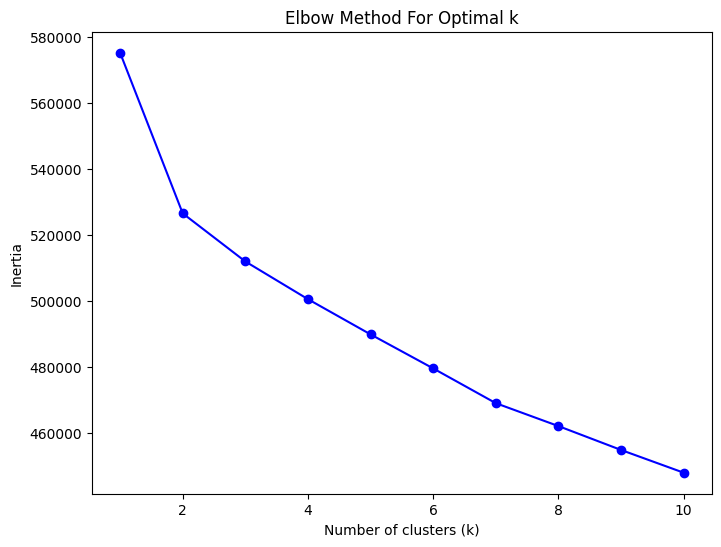

In [202]:
def plot_elbow_method(embeddings):
    inertias = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(K, inertias, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

plot_elbow_method(embeddings_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

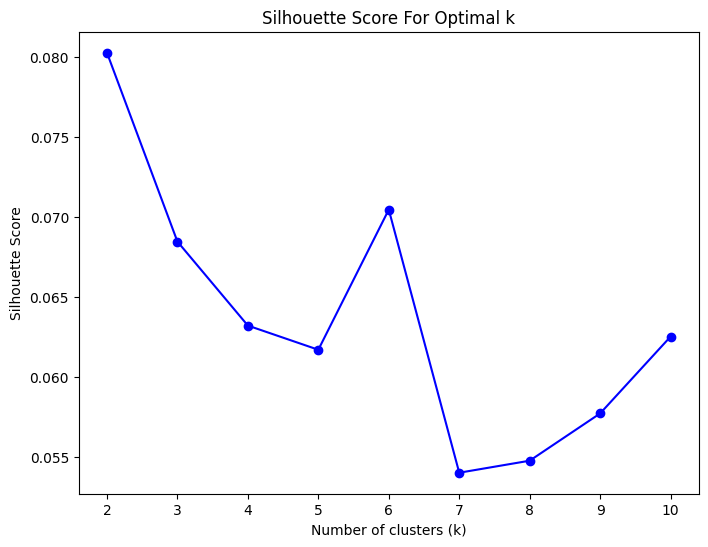

In [203]:
def plot_silhouette_score(embeddings):
    silhouette_scores = []
    K = range(2, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        silhouette_scores.append(score)

    plt.figure(figsize=(8, 6))
    plt.plot(K, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score For Optimal k')
    plt.show()

plot_silhouette_score(embeddings_scaled)


**Experimentation with different Ks and clustering algorithms**

In [204]:
N_CLUSTERS = 6

K MEANS

In [205]:
# K-means clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings_scaled)
df['kmeans_cluster'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**DBSCAN**

In [206]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.000001, min_samples=3)
dbscan_labels = dbscan.fit_predict(embeddings_scaled)
df['dbscan_cluster'] = dbscan_labels

**Visualizing both results using PCA**

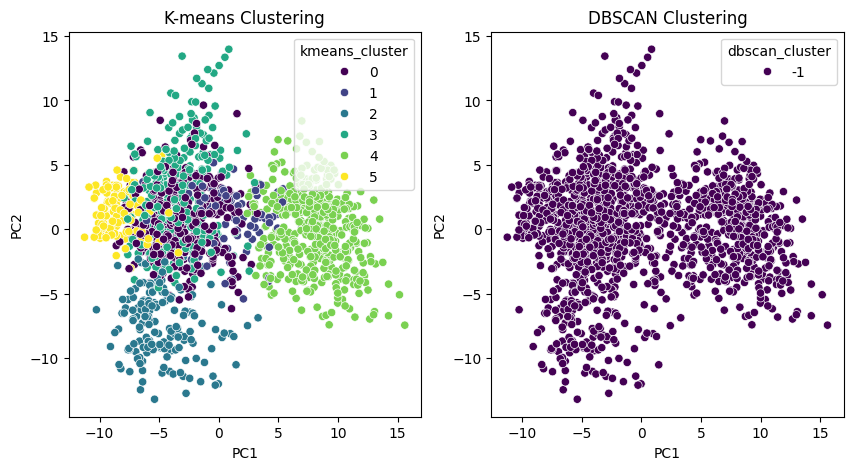

In [207]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
pca_df['kmeans_cluster'] = kmeans_labels
pca_df['dbscan_cluster'] = dbscan_labels

# Plot K-means clusters
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='viridis')
plt.title('K-means Clustering')

# Plot DBSCAN clusters
plt.subplot(1, 2, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='dbscan_cluster', palette='viridis')
plt.title('DBSCAN Clustering')

plt.show()

**Trying Agglomerative Clustering**

In [208]:
# Perform agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS)
agg_labels = agg_clustering.fit_predict(embeddings_scaled)

df['agg_cluster'] = agg_labels

**Trying Spectral Clustering**

In [209]:
# Perform spectral clustering
spectral_clustering = SpectralClustering(n_clusters=N_CLUSTERS, affinity='nearest_neighbors')
spectral_labels = spectral_clustering.fit_predict(embeddings_scaled)

df['spectral_cluster'] = spectral_labels

**Trying MeanShift Clustering**

In [210]:
# Perform mean shift clustering
mean_shift = MeanShift()
mean_shift_labels = mean_shift.fit_predict(embeddings_scaled)

df['mean_shift_cluster'] = mean_shift_labels

**Trying Affinity Clustering**

In [211]:
# Perform affinity propagation clustering
affinity_propagation = AffinityPropagation()
affinity_labels = affinity_propagation.fit_predict(embeddings_scaled)

df['affinity_cluster'] = affinity_labels

**Trying HDBSCAN Clustering**

In [212]:
# Perform HDBSCAN clustering
hdbscan_clustering = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=N_CLUSTERS)
hdbscan_labels = hdbscan_clustering.fit_predict(embeddings_scaled)

df['hdbscan_cluster'] = hdbscan_labels

**Visualizing Clustering Results**

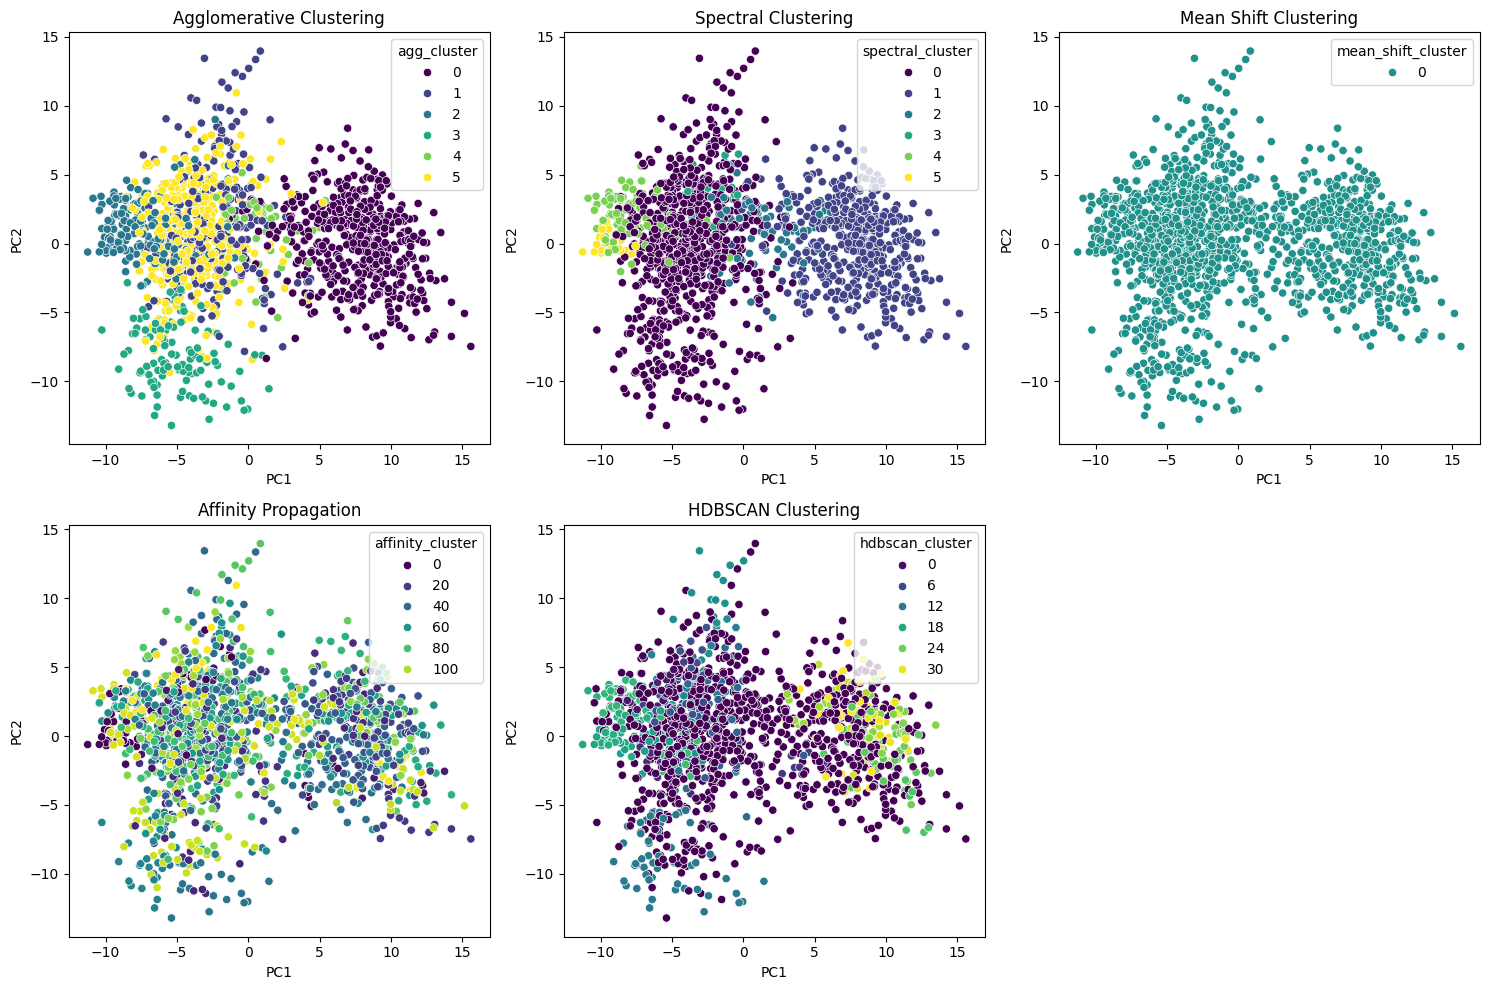

In [213]:
# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

# Add cluster labels for visualization
pca_df['agg_cluster'] = agg_labels
pca_df['spectral_cluster'] = spectral_labels
pca_df['mean_shift_cluster'] = mean_shift_labels
pca_df['affinity_cluster'] = affinity_labels
pca_df['hdbscan_cluster'] = hdbscan_labels

# Plot clusters
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='agg_cluster', palette='viridis')
plt.title('Agglomerative Clustering')

plt.subplot(2, 3, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='spectral_cluster', palette='viridis')
plt.title('Spectral Clustering')

plt.subplot(2, 3, 3)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='mean_shift_cluster', palette='viridis')
plt.title('Mean Shift Clustering')

plt.subplot(2, 3, 4)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='affinity_cluster', palette='viridis')
plt.title('Affinity Propagation')

plt.subplot(2, 3, 5)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='hdbscan_cluster', palette='viridis')
plt.title('HDBSCAN Clustering')

plt.tight_layout()
plt.show()


**Since Agglomerrative Clustering looks good, Let's try finding the best K for it using silhouette score**

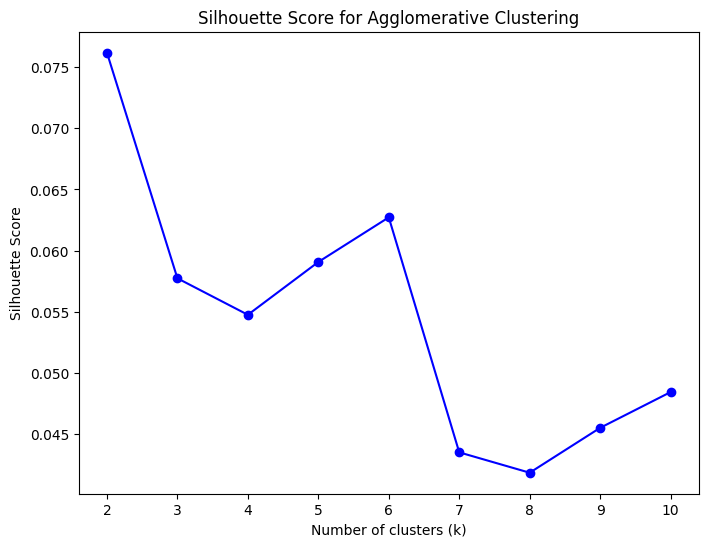

In [214]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
K = range(2, 11)  # Number of clusters to try
for k in K:
    agglomerative = AgglomerativeClustering(n_clusters=k)
    labels = agglomerative.fit_predict(embeddings_scaled)
    silhouette_scores.append(silhouette_score(embeddings_scaled, labels))

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.show()

**Using TSNE and PCA (for K-Means) for dimensionality reduction and then visualizing results**

In [216]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Perform KMeans Clustering
kmeans = KMeans(n_clusters=6)
kmeans_labels = kmeans.fit_predict(embeddings_scaled)
# Print distribution of clusters
cluster_distribution = np.bincount(kmeans_labels)
for cluster, count in enumerate(cluster_distribution):
    print(f"Cluster {cluster}: {count} instances")
df['kmeans_label'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: 344 instances
Cluster 1: 135 instances
Cluster 2: 280 instances
Cluster 3: 267 instances
Cluster 4: 153 instances
Cluster 5: 319 instances


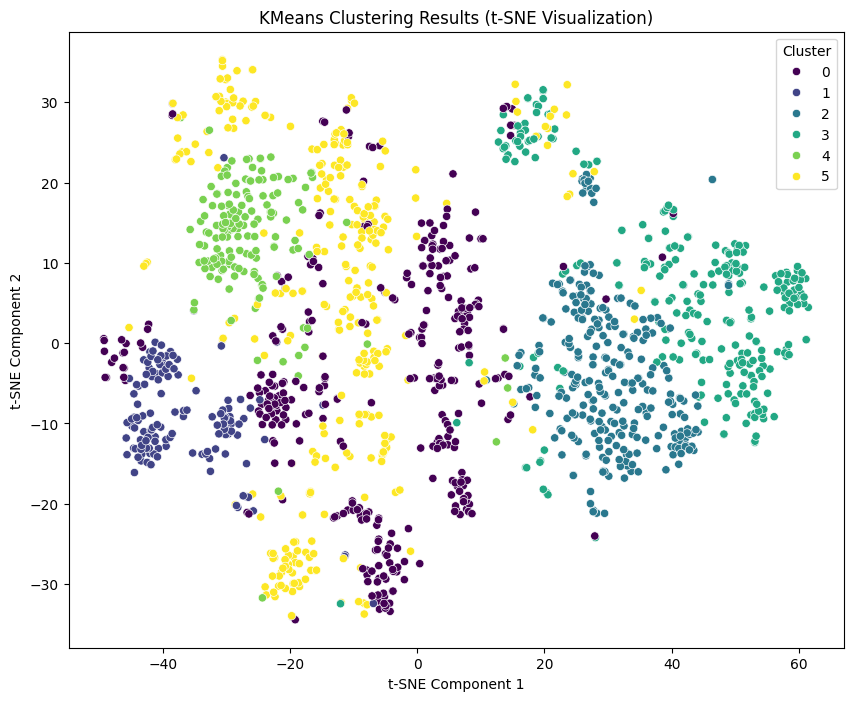

In [217]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)

# Visualize clusters with t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=kmeans_labels, palette='viridis', legend='full')
plt.title('KMeans Clustering Results (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


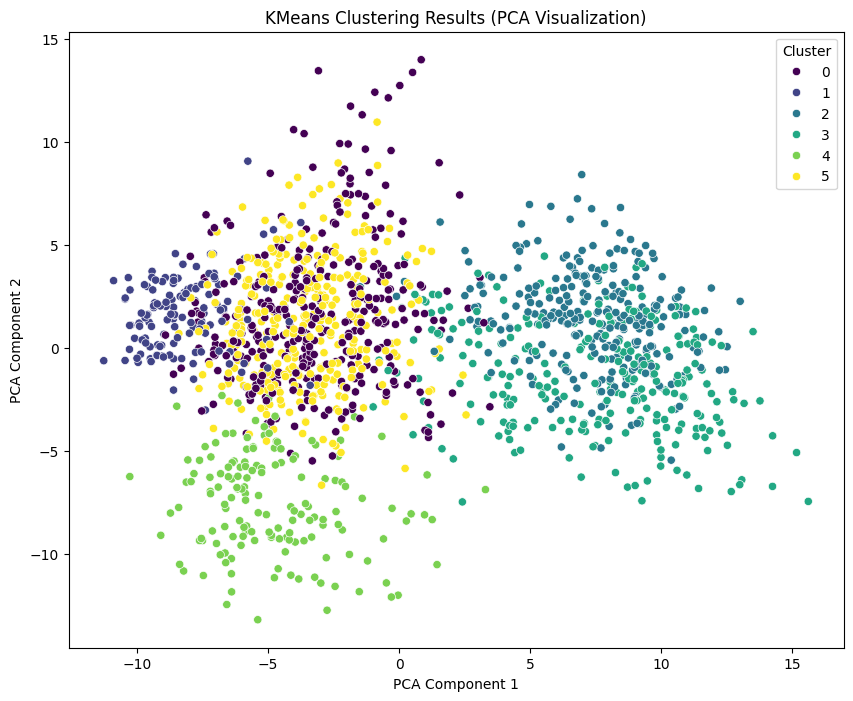

In [218]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_scaled)

# Visualize clusters with PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], hue=kmeans_labels, palette='viridis', legend='full')
plt.title('KMeans Clustering Results (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Final Number of Clusters  = 6
# Final Clustering Algorithm = K Means Clustering
Reason for picking KMeans:


1.   Decent clustering performance
2.   Availability of "predict" function to assign clusters to new unseen data



In [219]:
joblib.dump(kmeans, 'salad_clustering_machine.pkl')

['salad_clustering_machine.pkl']

**Defining a script for getting cluster for any new data**

In [220]:
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.cluster import  KMeans

# Download NLTK data files
nltk.download('punkt')

# Load the Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def removeStopwords(text):
    stop_words = set(stopwords.words('english'))
    # all verbs also must be removed
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    non_verbs = [word for word, tag in pos_tags if not tag.startswith('VB')]
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lWords = [lemmatizer.lemmatize(word) for word in words]
    lText = ' '.join(lWords)
    return lText

# Preprocess the new text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'oz', '', text)
    text = re.sub(r'lb', '', text)
    text = re.sub(r'[\d_]+', '', text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text

# Load the trained Agglomerative Clustering model
def load_agglomerative_model():
    agglomerative_model = joblib.load('salad_clustering_machine.pkl')
    return agglomerative_model

# Convert text to embeddings
def text_to_embeddings(text):
    embeddings = model.encode([text])
    return embeddings

# Function to assign new text to the appropriate cluster
def assign_to_cluster(new_text):
    # Load Agglomerative Clustering model
    agglomerative_model = load_agglomerative_model()

    # Preprocess the new text
    preprocessed_text = preprocess_text(new_text)

    # Convert text to embeddings
    new_embeddings = text_to_embeddings(preprocessed_text)

    # Predict cluster for new text
    cluster_label = agglomerative_model.predict(new_embeddings)[0]

    return cluster_label



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [221]:
df['cluster_label'] = df['salad_info'].apply(assign_to_cluster)

In [222]:
df = df[['salad_info','Original_text', 'cluster_label', 'kmeans_label']]

In [251]:
df.to_csv('train_salad_clustered.csv', index=False)

In [223]:
df.cluster_label.value_counts()

cluster_label
0    850
5    303
2    208
3    137
Name: count, dtype: int64

In [224]:
df.kmeans_label.value_counts()

kmeans_label
0    344
5    319
2    280
3    267
4    153
1    135
Name: count, dtype: int64

In [225]:
new_text = """

Mediterranean Salad Ingredients: - Crisp Romaine lettuce - Juicy tomatoes - Cucumbers - Kalamata olives - Red onion slices - Crumbled feta cheese -
Extra virgin olive oil - Lemon juice - Garlic - Dried oregano - Salt - Pepper
Wash and chop Romaine lettuce, tomatoes, and cucumbers. - Slice red onion thinly. - Pit and halve Kalamata olives. -
In a large bowl, combine lettuce, tomatoes, cucumbers, olives, and red onion. - Crumble feta cheese over the top. - In a small bowl, whisk together olive oil, lemon juice, minced garlic, dried oregano,
salt, and pepper to make the dressing. - Drizzle the dressing over the salad and toss gently to coat. - Serve immediately and enjoy the flavors of the Mediterranean!"""
cluster_label = assign_to_cluster(new_text)
print("Assigned cluster label:", cluster_label)


Assigned cluster label: 0


In [226]:
new_text = """

Beetroot Quinoa and Walnut Salad Ingredients: - Earthy beetroot - Nutty quinoa - Crunchy walnuts - Carrots - Cucumbers - Zesty
citrus vinaigrette
Cook quinoa according to package instructions. - Roast or boil beetroot until tender, then dice. - Chop carrots and cucumbers. - In a
large bowl, combine cooked quinoa, diced beetroot, chopped carrots, cucumbers, and walnuts. - Prepare the zesty citrus vinaigrette.
- Drizzle the vinaigrette over the salad and toss gently to coat

"""
cluster_label = assign_to_cluster(new_text)
print("Assigned cluster label:", cluster_label)


Assigned cluster label: 0


In [227]:
new_text = """

Desi Kachumar Salad Ingredients: - Crusty carrots - Tangy tomatoes - Crisp onions - Juicy cucumbers - Tender
boiled peanuts - Indian-spice dressing (mildly spicy, zesty, with chaat masala)
Peel and dice carrots. - Chop tomatoes and onions. - Peel and dice cucumbers. - Boil peanuts until tender. -
In a large bowl, combine carrots, tomatoes, onions, cucumbers, and boiled peanuts. - Prepare the Indian-spice
dressing with chaat masala, mixing well. - Drizzle the dressing over the salad and toss gently to coat. - Serve
this tantalizing Desi Kachumar Salad as a refreshing summer essential.

"""
cluster_label = assign_to_cluster(new_text)
print("Assigned cluster label:", cluster_label)


Assigned cluster label: 0


In [228]:
suggestions = df[df['kmeans_label'] == 1]
print(list(suggestions.sample(n=3)['Original_text'])[0])

Broccoli Raisin Salad

Ingredients:
- 1 lb. fresh broccoli
- 1/3 c. raisins
- 2 Tbsp. onion
- 2 slices bacon, cooked
- 3 oz. cream cheese
- 2 Tbsp. sugar
- 2 Tbsp. white vinegar
- 2 Tbsp. vegetable oil
- 1 Tbsp. mustard
- 1 clove garlic

Directions:
- Rinse broccoli well and cut flowerets into bite-size pieces. Toss with raisins, onion and crisp bacon pieces.
- Combine cream cheese and remaining ingredients in blender.
- Pour over broccoli. Mix well.
- Serve well chilled.


# Grouping of the salads sold so far!

In [229]:
s_df = pd.read_csv('salads_to_date.csv')
s_df.head()

,Salads,Order
0,Mexican Black Bean and Corn Salad\nIngredients...,12
1,Asian Sesame Noodle Salad\nIngredients: - Soba...,10
2,Mediterranean Chickpea Salad\nIngredients: - C...,18
3,Caprese Salad\nIngredients: - Fresh mozzarella...,12
4,Thai Mango Salad\nIngredients: - Ripe mango - ...,14


In [230]:
s_df.columns

Index(['Salads', 'Order'], dtype='object')

In [231]:
s_df.columns = ['text','orders']
s_df['processed_text'] = s_df['text'].apply(lambda x: preprocess_text(x))
s_df['category'] = s_df['processed_text'].apply(lambda x: assign_to_cluster(x))


In [232]:
s_df

,text,orders,processed_text,category
0,Mexican Black Bean and Corn Salad\nIngredients...,12,mexican black bean corn salad ingredient black...,0
1,Asian Sesame Noodle Salad\nIngredients: - Soba...,10,asian sesame noodle salad ingredient soba nood...,0
2,Mediterranean Chickpea Salad\nIngredients: - C...,18,mediterranean chickpea salad ingredient chickp...,0
3,Caprese Salad\nIngredients: - Fresh mozzarella...,12,caprese salad ingredient fresh mzarella tomato...,0
4,Thai Mango Salad\nIngredients: - Ripe mango - ...,14,thai mango salad ingredient ripe mango red bel...,0
5,Greek Orzo Salad\nIngredients: - Orzo pasta - ...,19,greek orzo salad ingredient orzo pasta cucumbe...,5
6,Southwest Quinoa Salad\nIngredients: - Quinoa ...,14,southwest quinoa salad ingredient quinoa black...,0
7,Tuscan Panzanella Salad\nIngredients: - Ciabat...,8,tuscan panzanella salad ingredient ciabatta br...,0
8,Kale Caesar Salad\nIngredients: - Kale - Crout...,10,kale caesar salad ingredient kale crouton parm...,5
9,Summer Berry Spinach Salad\nIngredients: - Bab...,8,summer berry spinach salad ingredient baby spi...,0


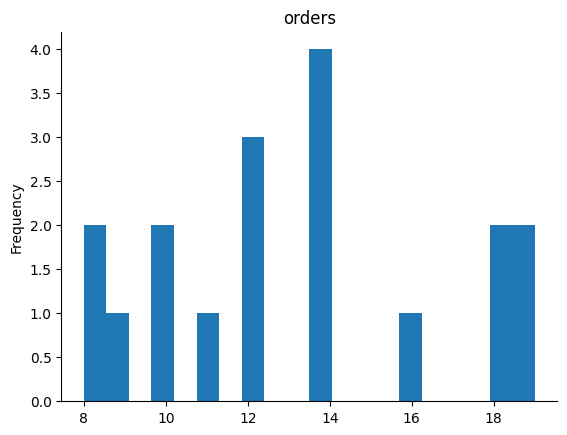

In [233]:
# @title orders

from matplotlib import pyplot as plt
s_df['orders'].plot(kind='hist', bins=20, title='orders')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [234]:
average_orders = s_df.groupby('category')['orders'].mean()

In [235]:
average_orders

category
0    12.307692
5    15.600000
Name: orders, dtype: float64

In [236]:
s_df.to_csv('salads_clustered.csv', index=False)

In [247]:
import random
def suggest_salad_to_user(df,liking,trainig_set = False):

  category_to_suggest = assign_to_cluster(liking)
  print(f'id_{category_to_suggest}')

  if trainig_set:
    category_col = 'cluster_label'
    recipe_col = 'Original_text'

  else:
    category_col = 'category'
    recipe_col = 'text'
  suggestions = df[df[category_col] == category_to_suggest]
  random_suggestions = df.sample(n=3)


  random_suggestions = list(random_suggestions[recipe_col])
  return random_suggestions



In [248]:
suggest_for = """

Hawaiian Poke Bowl Salad
Ingredients: - Sushi-grade tuna or salmon - Sushi rice or mixed greens - Avocado - Cucumber - Edamame - Mango - Seaweed salad - Green onions - Sesame seeds - Soy sauce - Sesame oil
- Rice vinegar - Honey - Ginger - Garlic. Cube sushi-grade tuna or salmon. - Cook sushi rice according to package instructions or wash and dry mixed greens. -
Dice avocado and cucumber. - Cook edamame. - Dice mango. - Drain seaweed salad. - Slice green onions. - In a large bowl, arrange sushi rice or mixed greens as a
base and top with cubed fish, avocado, cucumber, edamame, mango, and seaweed salad. - Sprinkle with sliced green onions and sesame seeds. - Prepare dressing by mixing
soy sauce, sesame oil, rice vinegar, honey, minced ginger, and minced garlic. - Drizzle dressing over salad and toss gently to coat.
"""

In [249]:
# Suggestions from Training set:
suggestions = suggest_salad_to_user(df,suggest_for, True)
for i in suggestions:
  print(i)
  print("-"*100)


id_0
Garden Macaroni Salad

Ingredients:
- 3/4 c. mayonnaise
- 1/4 tsp. basil
- 1 tsp. salt
- 1 (8 oz.) pkg. elbow macaroni, cooked
- 1 c. diced celery
- 1/4 c. sliced radishes
- 2 Tbsp. thinly sliced green onion
- 2 medium tomatoes, diced
- 1/4 c. diced green pepper (optional)

Directions:
- Stir together first 3 ingredients.
- Add remaining ingredients; toss.
- Cover and chill.
- Makes 8 cups.
----------------------------------------------------------------------------------------------------
German Potato Salad

Ingredients:
- 4 lb. potatoes, cooked
- 6 slices bacon, diced
- 1/2 c. sugar
- 3 Tbsp. flour
- 2 tsp. salt
- 1/4 tsp. pepper
- 1 c. cider vinegar
- 1 c. water
- 4 green onions, sliced

Directions:
- Peel and cut potatoes in thin slices.
- Fry bacon until crisp. Remove bacon from grease and reserve 1/2 cup drippings to make dressing.
- Blend sugar, flour, salt and pepper.
- Stir into bacon drippings to make smooth paste.
- Add vinegar and water.
- Boil 2 to 3 minutes.
- Combi

In [250]:
# Suggestions from Actual sold:
suggestions = suggest_salad_to_user(s_df,suggest_for, False)
for i in suggestions:
  print(i)
  print("-"*100)


id_0
Mexican Black Bean and Corn Salad
Ingredients: - Black beans - Corn kernels - Red bell pepper - Red onion - Cherry tomatoes - Avocado - Cilantro - Lime juice - Olive oil - Cumin - Salt - Pepper.
Procedure: - Drain and rinse black beans. - Cook corn kernels. - Dice red bell pepper, red onion, cherry tomatoes, and avocado. - Chop cilantro. - In a large bowl, combine all ingredients. - Prepare dressing by mixing lime juice, olive oil, cumin, salt, and pepper. - Drizzle dressing over salad and toss gently to coat.
----------------------------------------------------------------------------------------------------
Spring Asparagus Salad
Ingredients: - Asparagus - Mixed greens - Radishes - Avocado - Goat cheese - Lemon vinaigrette (lemon juice, olive oil, Dijon mustard, honey) - Salt - Pepper.
Procedure: - Trim and blanch asparagus. - Wash and dry mixed greens. - Slice radishes thinly. - Dice avocado. - Crumble goat cheese. - In a large bowl, combine asparagus, mixed greens, radishes, a